In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd gdrive/MyDrive/my_ml_2023/session-9

In [ ]:
# !pip uninstall -y torchtext
# !pip install torchtext==0.5.0
!pip install torchtext==0.5.0

In [ ]:
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torchtext
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import random

# import import_ipynb
import utils

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

# to get reproducible results:
torch.manual_seed(1234)
np.random.seed(1234)

**IMBD dataset**: 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews. The reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

Examples:

*If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it. Great Camp!!!*<br>
**positive**

*This movie features Charlie Spradling dancing in a strip club. Beyond that, it features a truly bad script with dull, unrealistic dialogue. That it got as many positive votes suggests some people may be joking.*<br>
**negative**

In [ ]:
from keras.datasets import imdb
from sklearn.model_selection import train_test_split

num_words = 5000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)


train_data, dev_data, train_labels, dev_labels = train_test_split(train_data, train_labels, test_size=0.2,
                                                    random_state=1234, stratify=train_labels)

In [ ]:
train_data.shape, train_labels.shape,  dev_labels.shape, dev_data.shape, test_data.shape, test_labels.shape

((20000,), (20000,), (5000,), (5000,), (25000,), (25000,))

In [ ]:
print(train_data[0])

[1, 13, 805, 8, 106, 14, 20, 11, 6, 1248, 1250, 315, 35, 2, 1973, 5, 387, 72, 376, 25, 490, 106, 233, 467, 148, 2331, 24, 14, 418, 7, 4294, 830, 151, 10, 10, 4, 86, 677, 234, 270, 4, 1163, 34, 815, 1509, 20, 489, 116, 916, 46, 7, 4, 1336, 114, 1299, 5, 1297, 1186, 5, 2003, 12, 214, 433, 103, 15, 14, 20, 127, 24, 28, 31, 686, 1907, 1698, 5, 246, 12, 9, 24, 78, 11, 6, 96, 15, 62, 97, 12, 163, 8, 106, 45, 43, 527, 207, 110, 179, 111, 102, 11, 61, 113, 5, 146, 24, 31, 7, 148, 2, 124, 32, 1418, 13, 384, 637, 358, 91, 102, 8, 49, 2826, 60, 48, 507, 78, 14, 31, 132, 10, 10, 2, 73, 788, 7, 14, 31, 61, 464]


In [ ]:
train_labels[0]

0

In [ ]:
word_index = imdb.get_word_index()

reverse_word_index = dict([(value+3, key) for (key, value) in word_index.items()])

reverse_word_index[0] = '[PAD]'
reverse_word_index[1] = '[START]'
reverse_word_index[2] = '[UNK]'
reverse_word_index[3] = '[UNS]'

Items in our dataset have a different number of words. PyTorch expects that the size of every item in a batch will be the same (so, we can process them simultaneously). Hence, we should truncate or pad our items to make them the same size. This can be done in different ways, but we use the following simple method:

In [ ]:
from torch.nn.utils.rnn import pad_sequence
import torch

max_len = 500

train_data = [sent[:max_len] for sent in train_data]
dev_data = [sent[:max_len] for sent in dev_data]
test_data = [sent[:max_len] for sent in test_data]

x_train = pad_sequence([torch.tensor(sent) for sent in train_data], batch_first=True)
x_dev = pad_sequence([torch.tensor(sent) for sent in dev_data], batch_first=True)
x_test = pad_sequence([torch.tensor(sent) for sent in test_data], batch_first=True)

In [ ]:
max([len(x) for x in x_test])

500

In [ ]:
def np2iter(x, y, shuffle=True):

  y = torch.tensor(y, dtype=torch.long)


  ds = torch.utils.data.TensorDataset(x, y)
  return torch.utils.data.DataLoader(ds, batch_size=64, shuffle=shuffle)

train_iter = np2iter(x_train, train_labels, shuffle=True)
dev_iter =  np2iter(x_dev, dev_labels, shuffle=False)
test_iter =  np2iter(x_test, test_labels, shuffle=False)

# Multilayer Perceptron
Let's build a simple model where we concatenate all input embeddings. Hence, we transform our input matrix to one big vector (dimension of embedding * max_len of sequence)

In [ ]:
class FlatModel(nn.Module):
  def __init__(self, emb_dim=50):
    super(FlatModel, self).__init__()

    self.embeddings = nn.Embedding(num_embeddings=num_words,
                                   embedding_dim=emb_dim, padding_idx=0)

    self.layer = nn.Sequential(nn.Linear(in_features=emb_dim*max_len, out_features=emb_dim),
                                nn.ReLU(),
                                nn.Linear(in_features=emb_dim, out_features=2))


  def forward(self, x):
    x = self.embeddings(x)
    x = torch.flatten(x, start_dim=1, end_dim=- 1)
    return self.layer(x)

In [ ]:
def val_acc(y_pred, y_test):
  y_pred = np.argmax(y_pred, axis=1)
  return accuracy_score(y_pred=y_pred, y_true=y_test)

In [ ]:
flat_model = FlatModel(emb_dim=300)
flat_model = flat_model.cuda()

history = utils.train(model=flat_model,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
              optimizer=torch.optim.Adam(flat_model.parameters(), lr=0.0001),
              train_ds=train_iter,
              dev_ds=dev_iter,
              num_epochs=20,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=3))

epoch 1 train loss: 0.6742 val_cls: 0.6497 val_acc: 0.6106
tensor(0.6497) None
epoch 2 train loss: 0.2484 val_cls: 0.7264 val_acc: 0.6238
tensor(0.7264) tensor(0.6497)
epoch 3 train loss: 0.0247 val_cls: 0.9112 val_acc: 0.6336
tensor(0.9112) tensor(0.6497)
epoch 4 train loss: 0.0035 val_cls: 1.0350 val_acc: 0.6352
tensor(1.0350) tensor(0.6497)
EARLY STOPPING 


/content/utils.py:364: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


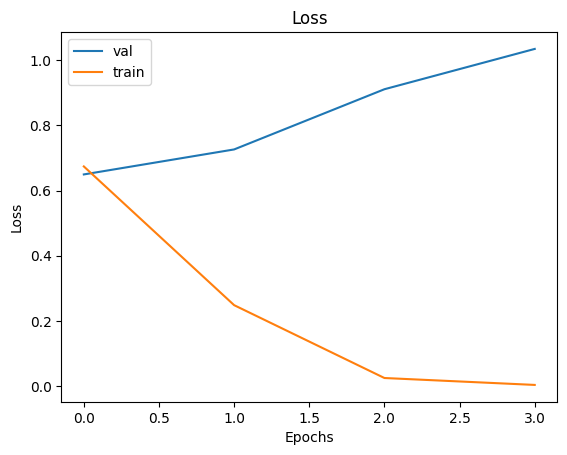

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
pred = utils.test(flat_model, test_iter)
pred = np.argmax(pred, axis=1)

print(classification_report(y_pred=pred, y_true=test_labels))

              precision    recall  f1-score   support

           0       0.63      0.61      0.62     12500
           1       0.62      0.64      0.63     12500

    accuracy                           0.62     25000
   macro avg       0.62      0.62      0.62     25000
weighted avg       0.62      0.62      0.62     25000



We can clearly see that the model is not learning much and  experience serious overfiting. Let's check the size of the model (46,500,902):

In [ ]:
sum(p.numel() for p in flat_model.parameters() if p.requires_grad)

46500902

The model is too big. Let's build another simple model where we average all input embeddings. Hence, we transform our input matrix to one small vector (dimension of embedding). For the first model, we observe similar results with the flat model, but our input has only 50 neurons!

In [ ]:
class AverageModel(nn.Module):
  def __init__(self, emb_dim=50):
    super(AverageModel, self).__init__()

    self.embeddings = nn.Embedding(num_embeddings=num_words,
                                   embedding_dim=emb_dim, padding_idx=0)

    self.layer = nn.Sequential(nn.Linear(in_features=emb_dim, out_features=emb_dim),
                                nn.ReLU(),
                                nn.Linear(in_features=emb_dim, out_features=2))


  def forward(self, x):
    # later we are going to mask zeros in the input to calculate average
    mask = x != 0
    x = self.embeddings(x)
    x = x.sum(dim=1)/mask.sum(dim=1,  keepdim=True)
    return self.layer(x)

In [ ]:
average_model = AverageModel(emb_dim=300)

average_model = average_model.cuda()

history = utils.train(model=average_model,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
              optimizer=torch.optim.Adam(average_model.parameters(), lr=0.0001),
              train_ds=train_iter,
              dev_ds=dev_iter,
              num_epochs=20,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=3))

epoch 1 train loss: 0.6624 val_cls: 0.6209 val_acc: 0.6910
tensor(0.6209) None
epoch 2 train loss: 0.5684 val_cls: 0.5221 val_acc: 0.7598
tensor(0.5221) tensor(0.6209)
epoch 3 train loss: 0.4830 val_cls: 0.4565 val_acc: 0.7958
tensor(0.4565) tensor(0.5221)
epoch 4 train loss: 0.4283 val_cls: 0.4170 val_acc: 0.8186
tensor(0.4170) tensor(0.4565)
epoch 5 train loss: 0.3912 val_cls: 0.3902 val_acc: 0.8322
tensor(0.3902) tensor(0.4170)
epoch 6 train loss: 0.3644 val_cls: 0.3714 val_acc: 0.8398
tensor(0.3714) tensor(0.3902)
epoch 7 train loss: 0.3433 val_cls: 0.3592 val_acc: 0.8462
tensor(0.3592) tensor(0.3714)
epoch 8 train loss: 0.3250 val_cls: 0.3469 val_acc: 0.8512
tensor(0.3469) tensor(0.3592)
epoch 9 train loss: 0.3109 val_cls: 0.3379 val_acc: 0.8534
tensor(0.3379) tensor(0.3469)
epoch 10 train loss: 0.2979 val_cls: 0.3306 val_acc: 0.8588
tensor(0.3306) tensor(0.3379)
epoch 11 train loss: 0.2861 val_cls: 0.3257 val_acc: 0.8632
tensor(0.3257) tensor(0.3306)
epoch 12 train loss: 0.2761 v

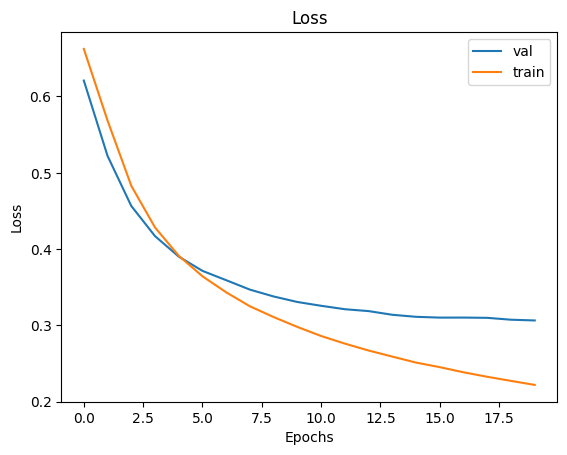

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
pred = utils.test(average_model, test_iter)
pred = np.argmax(pred, axis=1)

print(classification_report(y_pred=pred, y_true=test_labels))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86     12500
           1       0.85      0.89      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [ ]:
sum(p.numel() for p in average_model.parameters() if p.requires_grad)

1590902

We can observe that the smaller model demostrates much better results.

### Simple RNN
Let's code our first RNN. However, simple RNN can not handle long sequences, and we will see it!

In [ ]:
class SimpleRNN(nn.Module):
  def __init__(self, emb_dim=50):
    super(SimpleRNN, self).__init__()

    self.embeddings = nn.Embedding(num_embeddings=num_words,
                                   embedding_dim=emb_dim, padding_idx=0)

    self.rnn = nn.RNN(input_size=emb_dim, hidden_size=emb_dim, num_layers=1,
                      batch_first=True)

    self.linear_layer = nn.Linear(in_features=emb_dim, out_features=2)


  def forward(self, x):
    # our sequences have different lengths; let's calculate it
    len_x = (x !=0).sum(1)

    x = self.embeddings(x)
    # this function packs our padded sequences and later
    #  makes sure that our RNNs do not read the padded part
    x = pack_padded_sequence(x, len_x.cpu(), batch_first=True,
                             enforce_sorted=False)

    #  we extract the last hidden state
    _, x = self.rnn(x)

    x = x[0]
    return self.linear_layer(x)



In [ ]:
simple_rnn = SimpleRNN(emb_dim=300)

simple_rnn = simple_rnn.cuda()

history = utils.train(model=simple_rnn,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
              optimizer=torch.optim.Adam(simple_rnn.parameters(), lr=0.0001),
              train_ds=train_iter,
              dev_ds=dev_iter,
              num_epochs=20,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=3))


epoch 1 train loss: 0.6637 val_cls: 0.5968 val_acc: 0.6818
tensor(0.5968) None
epoch 2 train loss: 0.5640 val_cls: 0.5755 val_acc: 0.6962
tensor(0.5755) tensor(0.5968)
epoch 3 train loss: 0.6375 val_cls: 0.6654 val_acc: 0.5842
tensor(0.6654) tensor(0.5755)
epoch 4 train loss: 0.6466 val_cls: 0.6523 val_acc: 0.6000
tensor(0.6523) tensor(0.5755)
epoch 5 train loss: 0.6242 val_cls: 0.6278 val_acc: 0.6316
tensor(0.6278) tensor(0.5755)
EARLY STOPPING 


/content/utils.py:364: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


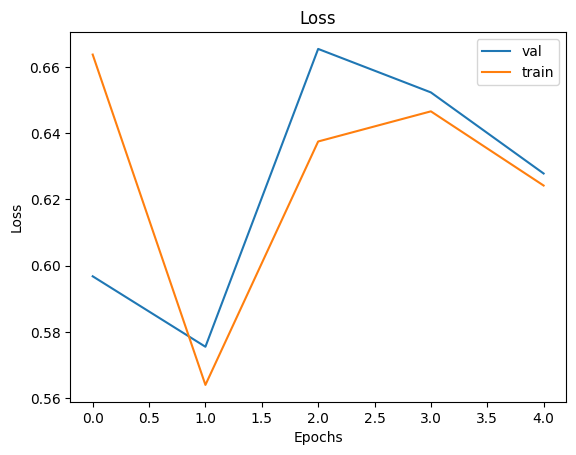

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
pred = utils.test(simple_rnn, test_iter)
pred = np.argmax(pred, axis=1)

print(classification_report(y_pred=pred, y_true=test_labels))

              precision    recall  f1-score   support

           0       0.80      0.50      0.61     12500
           1       0.64      0.88      0.74     12500

    accuracy                           0.69     25000
   macro avg       0.72      0.69      0.67     25000
weighted avg       0.72      0.69      0.67     25000



### LSTMs

Let's try LSTMs:

In [ ]:
class LSTM(nn.Module):
  def __init__(self, emb_dim=50):
    super(LSTM, self).__init__()

    self.embeddings = nn.Embedding(num_embeddings=num_words,
                                   embedding_dim=emb_dim, padding_idx=0)

    self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=emb_dim, num_layers=1,
                      batch_first=True)

    self.linear_layer = nn.Linear(in_features=emb_dim, out_features=2)


  def forward(self, x):
    # our sequences have different lengths; let's calculate it
    len_x = (x !=0).sum(1)


    x = self.embeddings(x)

    # this function packs our padded sequences and later
    #  makes sure that our RNNs do not read the padded part
    x = pack_padded_sequence(x, len_x.cpu(), batch_first=True,
                             enforce_sorted=False)
    #  we extract the last hidden state
    _, (x, _) = self.rnn(x)
    x = x[0]
    return self.linear_layer(x)

In [ ]:
lstm = LSTM(emb_dim=300)

lstm = lstm.cuda()

history = utils.train(model=lstm,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
              optimizer=torch.optim.Adam(lstm.parameters(), lr=0.0001),
              train_ds=train_iter,
              dev_ds=dev_iter,
              num_epochs=20,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=3))



epoch 1 train loss: 0.6512 val_cls: 0.5149 val_acc: 0.7436
tensor(0.5149) None
epoch 2 train loss: 0.4769 val_cls: 0.4216 val_acc: 0.8088
tensor(0.4216) tensor(0.5149)
epoch 3 train loss: 0.4304 val_cls: 0.3901 val_acc: 0.8250
tensor(0.3901) tensor(0.4216)
epoch 4 train loss: 0.3596 val_cls: 0.3690 val_acc: 0.8388
tensor(0.3690) tensor(0.3901)
epoch 5 train loss: 0.3293 val_cls: 0.3904 val_acc: 0.8316
tensor(0.3904) tensor(0.3690)
epoch 6 train loss: 0.2995 val_cls: 0.3441 val_acc: 0.8526
tensor(0.3441) tensor(0.3690)
epoch 7 train loss: 0.2758 val_cls: 0.3626 val_acc: 0.8548
tensor(0.3626) tensor(0.3441)
epoch 8 train loss: 0.2457 val_cls: 0.3285 val_acc: 0.8632
tensor(0.3285) tensor(0.3441)
epoch 9 train loss: 0.2307 val_cls: 0.3486 val_acc: 0.8628
tensor(0.3486) tensor(0.3285)
epoch 10 train loss: 0.2086 val_cls: 0.3233 val_acc: 0.8618
tensor(0.3233) tensor(0.3285)
epoch 11 train loss: 0.1955 val_cls: 0.3714 val_acc: 0.8362
tensor(0.3714) tensor(0.3233)
epoch 12 train loss: 0.1732 v

/content/utils.py:364: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


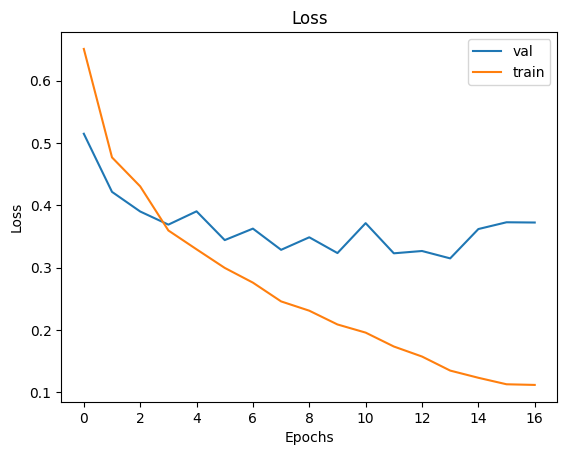

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
pred = utils.test(lstm, test_iter)
pred = np.argmax(pred, axis=1)

print(classification_report(y_pred=pred, y_true=test_labels))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87     12500
           1       0.87      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [ ]:
sum(p.numel() for p in LSTM(300).parameters() if p.requires_grad)

2223002

### Pretrained embeddings
Let's download pre-trained embeddings into a dictionary where keys correspond to tokens (or words) and values correspond to embeddings:

In [ ]:
glove_vectors = torchtext.vocab.GloVe('6B', dim=50)

.vector_cache/glove.6B.zip: 862MB [02:42, 5.30MB/s]                           
100%|█████████▉| 399999/400000 [00:13<00:00, 29908.63it/s]


In [ ]:
glove_vectors.get_vecs_by_tokens(["hello"], lower_case_backup=True)

tensor([[-0.3850,  0.8009,  0.0641, -0.2835, -0.0268, -0.3453, -0.6425, -0.1173,
         -0.3326,  0.5524, -0.0878,  0.9035,  0.4710,  0.5666,  0.6985, -0.3523,
         -0.8654,  0.9057,  0.0358, -0.0717, -0.1233,  0.5492,  0.4701,  0.3557,
          1.2611, -0.6758, -0.9498,  0.6867,  0.3871, -1.3492,  0.6351,  0.4642,
         -0.4881,  0.8383, -0.9246, -0.3372,  0.5374, -1.0616, -0.0814, -0.6711,
          0.3092, -0.3923, -0.5500, -0.6883,  0.5805, -0.1163,  0.0131, -0.5765,
          0.0488,  0.6720]])

In [ ]:
lstm = LSTM(emb_dim=300)

emb_matrix = utils.build_embed_matrix(reverse_word_index=reverse_word_index,
                                      dim=300, num_words=num_words)

lstm.embeddings.from_pretrained(emb_matrix, freeze=False)
lstm = lstm.cuda()

history = utils.train(model=lstm,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
              optimizer=torch.optim.Adam(lstm.parameters(), lr=0.0001),
              train_ds=train_iter,
              dev_ds=dev_iter,
              num_epochs=20,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=3))

100%|█████████▉| 399999/400000 [00:53<00:00, 7415.56it/s]


epoch 1 train loss: 0.6518 val_cls: 0.5554 val_acc: 0.7092
tensor(0.5554) None
epoch 2 train loss: 0.4644 val_cls: 0.4410 val_acc: 0.7984
tensor(0.4410) tensor(0.5554)
epoch 3 train loss: 0.3937 val_cls: 0.3825 val_acc: 0.8306
tensor(0.3825) tensor(0.4410)
epoch 4 train loss: 0.3458 val_cls: 0.3566 val_acc: 0.8486
tensor(0.3566) tensor(0.3825)
epoch 5 train loss: 0.3298 val_cls: 0.4364 val_acc: 0.8300
tensor(0.4364) tensor(0.3566)
epoch 6 train loss: 0.2817 val_cls: 0.3861 val_acc: 0.8226
tensor(0.3861) tensor(0.3566)
epoch 7 train loss: 0.2515 val_cls: 0.3216 val_acc: 0.8628
tensor(0.3216) tensor(0.3566)
epoch 8 train loss: 0.2272 val_cls: 0.3194 val_acc: 0.8690
tensor(0.3194) tensor(0.3216)
epoch 9 train loss: 0.2088 val_cls: 0.3372 val_acc: 0.8632
tensor(0.3372) tensor(0.3194)
epoch 10 train loss: 0.1903 val_cls: 0.3482 val_acc: 0.8658
tensor(0.3482) tensor(0.3194)
epoch 11 train loss: 0.1821 val_cls: 0.3904 val_acc: 0.8564
tensor(0.3904) tensor(0.3194)
EARLY STOPPING 


/content/utils.py:364: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


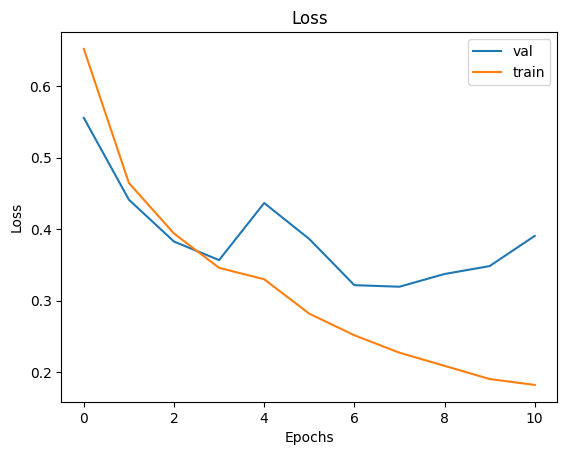

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
pred = utils.test(lstm, test_iter)
pred = np.argmax(pred, axis=1)

print(classification_report(y_pred=pred, y_true=test_labels))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86     12500
           1       0.85      0.89      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



We can freeze embeddings (not train) to reduce the number of the parameters and get stiil good results.

In [ ]:
lstm = LSTM(emb_dim=300)

emb_matrix = utils.build_embed_matrix(reverse_word_index=reverse_word_index,
                                      dim=300, num_words=num_words)

lstm.embeddings.from_pretrained(emb_matrix, freeze=True)
lstm.embeddings.weight.requires_grad = False

lstm = lstm.cuda()

history = utils.train(model=lstm,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
              optimizer=torch.optim.Adam(lstm.parameters(), lr=0.0001),
              train_ds=train_iter,
              dev_ds=dev_iter,
              num_epochs=20,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=3))

/usr/local/lib/python3.10/dist-packages/torchtext/vocab.py:432: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.itos, self.stoi, self.vectors, self.dim = torch.load(path_

epoch 1 train loss: 0.6568 val_cls: 0.5856 val_acc: 0.6848
tensor(0.5856) None
epoch 2 train loss: 0.5052 val_cls: 0.4438 val_acc: 0.7990
tensor(0.4438) tensor(0.5856)
epoch 3 train loss: 0.4121 val_cls: 0.4199 val_acc: 0.8042
tensor(0.4199) tensor(0.4438)
epoch 4 train loss: 0.3761 val_cls: 0.3808 val_acc: 0.8314
tensor(0.3808) tensor(0.4199)
epoch 5 train loss: 0.3258 val_cls: 0.4013 val_acc: 0.8208
tensor(0.4013) tensor(0.3808)
epoch 6 train loss: 0.2977 val_cls: 0.3814 val_acc: 0.8368
tensor(0.3814) tensor(0.3808)
epoch 7 train loss: 0.2793 val_cls: 0.3303 val_acc: 0.8580
tensor(0.3303) tensor(0.3808)
epoch 8 train loss: 0.2383 val_cls: 0.3160 val_acc: 0.8686
tensor(0.3160) tensor(0.3303)
epoch 9 train loss: 0.2254 val_cls: 0.3345 val_acc: 0.8714
tensor(0.3345) tensor(0.3160)
epoch 10 train loss: 0.2079 val_cls: 0.3283 val_acc: 0.8644
tensor(0.3283) tensor(0.3160)
epoch 11 train loss: 0.1810 val_cls: 0.3214 val_acc: 0.8740
tensor(0.3214) tensor(0.3160)
EARLY STOPPING 


/content/utils.py:364: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


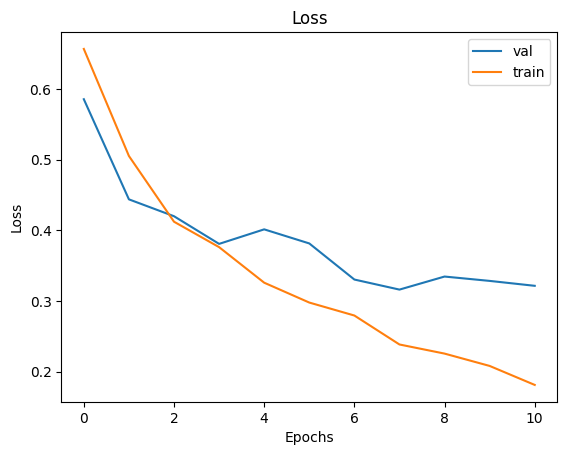

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
pred = utils.test(lstm, test_iter)
pred = np.argmax(pred, axis=1)

print(classification_report(y_pred=pred, y_true=test_labels))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87     12500
           1       0.88      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [ ]:
sum(p.numel() for p in lstm.parameters() if p.requires_grad)

723002

We even can train LSTMs with random embeddings:

In [ ]:
lstm = LSTM(emb_dim=300)

lstm.embeddings.weight.requires_grad = False

lstm = lstm.cuda()

history = utils.train(model=lstm,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
              optimizer=torch.optim.Adam(lstm.parameters(), lr=0.0001),
              train_ds=train_iter,
              dev_ds=dev_iter,
              num_epochs=20,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=3))

epoch 1 train loss: 0.6620 val_cls: 0.5915 val_acc: 0.6910
tensor(0.5915) None
epoch 2 train loss: 0.5131 val_cls: 0.4526 val_acc: 0.7956
tensor(0.4526) tensor(0.5915)
epoch 3 train loss: 0.4282 val_cls: 0.4072 val_acc: 0.8150
tensor(0.4072) tensor(0.4526)
epoch 4 train loss: 0.3851 val_cls: 0.3837 val_acc: 0.8320
tensor(0.3837) tensor(0.4072)
epoch 5 train loss: 0.3563 val_cls: 0.3785 val_acc: 0.8346
tensor(0.3785) tensor(0.3837)
epoch 6 train loss: 0.3087 val_cls: 0.3568 val_acc: 0.8452
tensor(0.3568) tensor(0.3785)
epoch 7 train loss: 0.2869 val_cls: 0.3322 val_acc: 0.8606
tensor(0.3322) tensor(0.3568)
epoch 8 train loss: 0.2708 val_cls: 0.3318 val_acc: 0.8620
tensor(0.3318) tensor(0.3322)
epoch 9 train loss: 0.2351 val_cls: 0.3441 val_acc: 0.8652
tensor(0.3441) tensor(0.3318)
epoch 10 train loss: 0.2207 val_cls: 0.3253 val_acc: 0.8690
tensor(0.3253) tensor(0.3318)
epoch 11 train loss: 0.1995 val_cls: 0.3444 val_acc: 0.8600
tensor(0.3444) tensor(0.3253)
epoch 12 train loss: 0.1949 v

/content/utils.py:364: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


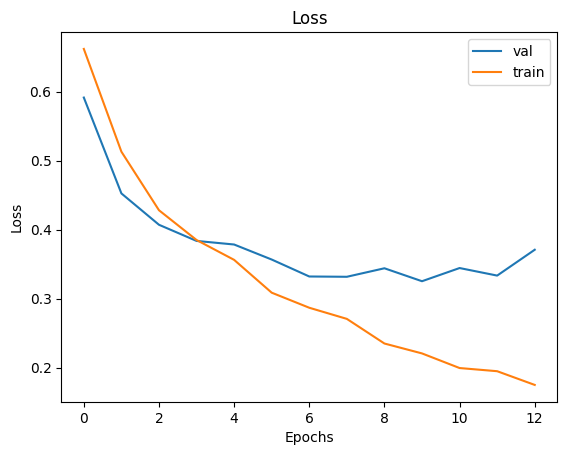

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
pred = utils.test(lstm, test_iter)
pred = np.argmax(pred, axis=1)

print(classification_report(y_pred=pred, y_true=test_labels))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87     12500
           1       0.85      0.89      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



### **Take-Home Message**:

1. **Simple RNNs Are Hard to Optimize**: Simple RNNs often face challenges like vanishing or exploding gradients, which make training difficult.

2. **LSTMs Are an Efficient Improvement**: LSTMs are a modified version of RNNs designed to handle these gradient issues effectively.

3. **Sequential Dependencies**: RNNs are useful for capturing the order and dependencies in text, but the performance boost compared to simpler methods like averaging embeddings depends on the specific task.

4. **Start with Pre-Trained Embeddings**: Using pre-trained embeddings (e.g., word2vec, GloVe) is a good starting point, but better results are not always guaranteed (it depends on the task and data).